In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

In [2]:
market_demand = pd.read_csv("FACT_MARKET_DEMAND-001.csv")

# Q6

Item Description: Diet Energy Moonlit Casava 2L Multi Jug
- Caloric Segment: Diet
- Market Category: Energy
- Manufacturer: Swire-CC
- Brand: Diet Moonlit
- Package Type: 2L Multi Jug
- Flavor: ‘Cassava’
  
Swire plans to release this product for 6 months. What will the forecasted demand be, in weeks, for this product?
roduct?


## Data Preparation

In [3]:
multi_jug_2l = market_demand[market_demand['PACKAGE']=='2L MULTI JUG']
diet_multi_jug_2l = multi_jug_2l[multi_jug_2l['CALORIC_SEGMENT']=='DIET/LIGHT']
swire_diet_multi_jug_2l = diet_multi_jug_2l[diet_multi_jug_2l['MANUFACTURER']=='SWIRE-CC']
swire_diet_multi_jug_2l_moonlit = swire_diet_multi_jug_2l[swire_diet_multi_jug_2l['BRAND'].str.contains('DIET MOONLIT', case=False, regex=True)]

In [4]:
df_6 = swire_diet_multi_jug_2l_moonlit[['DATE','UNIT_SALES']].groupby(by="DATE", as_index=False).sum()
df_6['DATE'] = pd.to_datetime(df_6['DATE'])
df_6.set_index('DATE', inplace=True)
df_6 = df_6.asfreq('W-SAT')

Text(0, 0.5, 'UNIT_SALES')

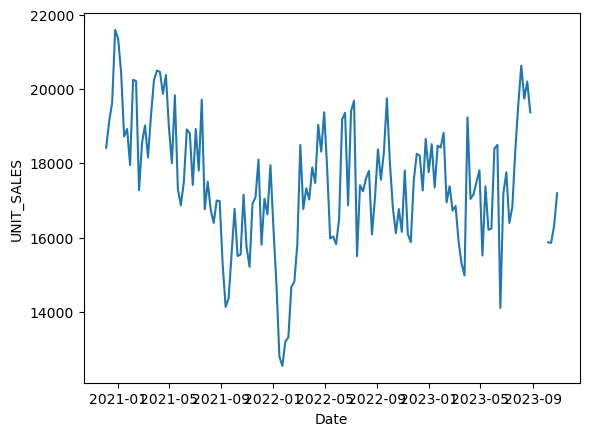

In [5]:
plt.plot(df_6)
plt.xlabel('Date')
plt.ylabel('UNIT_SALES')

There are NAN in some weeks. as we dig deeper we see that there are no sale on the month of august 2023.

In [6]:
# Train and Test periods
from datetime import datetime

s_date = '2023-02-25'
e_date = '2023-08-26'
df_6 = df_6.loc[df_6.index <= e_date]
train_period = df_6.loc[df_6.index < s_date]
test_period = df_6.loc[(df_6.index >= s_date) & (df_6.index <= e_date)]


start_forecast = datetime.strptime(s_date, '%Y-%m-%d').date()
end_forecast = datetime.strptime(e_date, '%Y-%m-%d').date()

# Model Performance Metrics Function

We will create and resuse this function to measure each models performance with the data. This will include MAE, MSE, RMSE, MAPE and direct accuracy percentage.

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import numpy as np

def get_scores(actual, predicted):
    # Calculate errors
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = sqrt(mse)
    percentage_diff = np.abs((actual - predicted) / actual) * 100

    # Calculate MAPE
    mape = percentage_diff.mean()

    # Calculate "Accuracy" Percentage
    accuracy_percentage = 100 - mape

    # Print metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}%")
    print(f"Direct 'Accuracy' Percentage: {accuracy_percentage}%")

    return pd.Series(data={'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'direct_accuracy':accuracy_percentage}, index=['mae', 'mse', 'rmse','mape','direct_accuracy'])

## ARIMA

ARIMA is a statistical model used for time series analysis to forecast future data points by leveraging past data. It combines three main aspects: autoregression (AR), differencing (I) to make the time series stationary, and moving average (MA). The AR part exploits the relationship between an observation and a number of lagged observations, the I part involves differencing the data to achieve stationarity, and the MA part models the error of the observation as a combination of previous error terms.

In [8]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA Model fitting
order = (1, 1, 1)  # Still (p, d, q)

model = ARIMA(train_period['UNIT_SALES'], order=order)
model_fit = model.fit()

# Forecasting
forecast = model_fit.predict(start=start_forecast,
                             end=end_forecast)

arima_forecast = forecast

In [9]:
arima_score = get_scores(test_period.squeeze(), arima_forecast)

MAE: 1331.9101181487447
MSE: 2785766.362578469
RMSE: 1669.0615215079608
MAPE: 7.579412439517313%
Direct 'Accuracy' Percentage: 92.42058756048269%


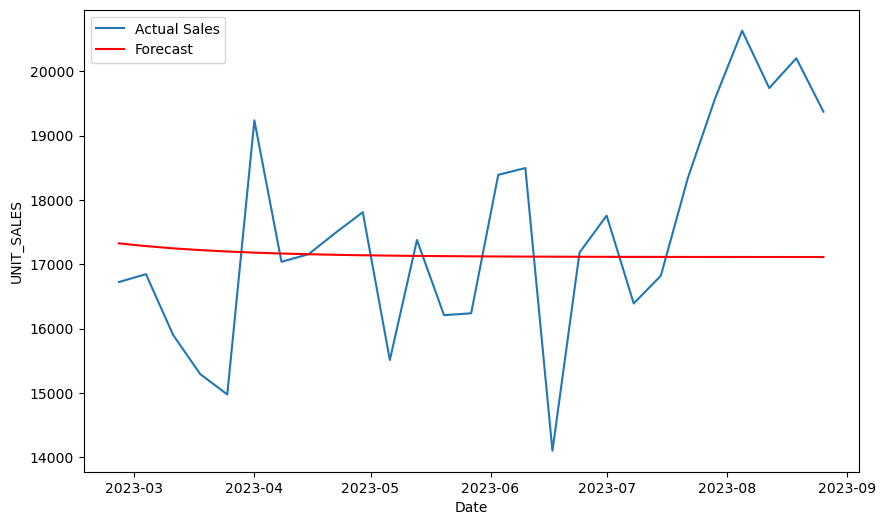

In [10]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(test_period['UNIT_SALES'], label='Actual Sales')
plt.plot(arima_forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('UNIT_SALES')
plt.legend()
plt.show()

## SARIMA

SARIMA extends ARIMA by explicitly accommodating and modeling seasonal effects in time series data. It includes additional seasonal elements on top of the AR, I, and MA components.
SARIMA is characterized by its ability to model both non-seasonal and seasonal components of the time series data, making it more versatile than ARIMA for data with clear seasonal patterns, such as sales data around specific holidays or events.
It incorporates additional parameters to handle seasonality, which are seasonal AR, seasonal differencing, and seasonal MA components, allowing it to capture seasonal fluctuations effectively, making it ideal for products with seasonal demand.

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


# SARIMA Model fitting
order = (1, 1, 1)  # (p, d, q)
seasonal_order = (1, 1, 1, 52)  # (P, D, Q, s)

model = SARIMAX(train_period['UNIT_SALES'], order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

# Forecasting
forecast = model_fit.predict(start=start_forecast.strftime('%Y-%m-%d'),
                             end=end_forecast.strftime('%Y-%m-%d'))
sarima_forecast = forecast

C:\Users\Michael Mendoza\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Michael Mendoza\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
sarima_score = get_scores(test_period.squeeze(), sarima_forecast)

MAE: 2078.657764078491
MSE: 5833349.344575272
RMSE: 2415.2327723379526
MAPE: 12.472789935052829%
Direct 'Accuracy' Percentage: 87.52721006494717%


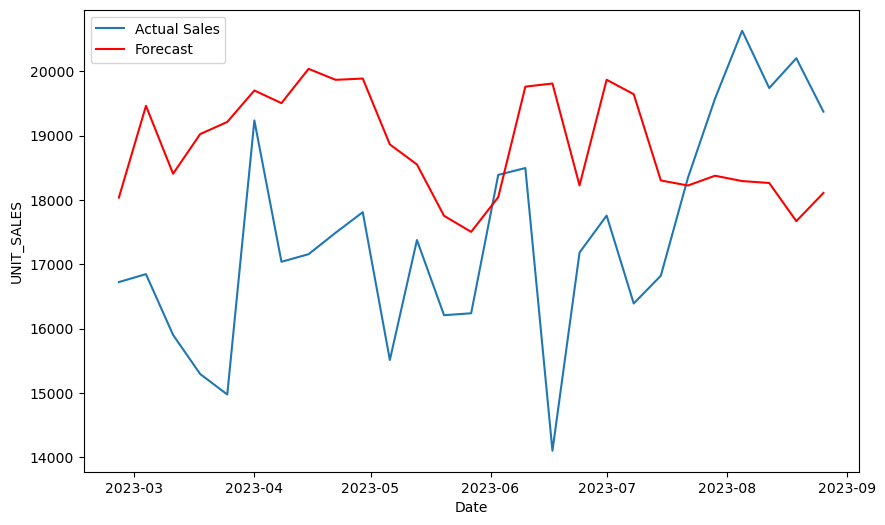

In [13]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(test_period['UNIT_SALES'], label='Actual Sales')
plt.plot(sarima_forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('UNIT_SALES')
plt.legend()
plt.show()

## Prophet

Prophet is a forecasting tool designed by Facebook for handling time series data that displays patterns on different time scales such as yearly, weekly, and daily. It is especially useful for data with strong seasonal effects and several seasons of historical data.
Prophet works by fitting nonlinear trends with yearly, weekly, and daily seasonality, plus holiday effects. It is robust to missing data and shifts in the trend, and typically requires no manual tuning of parameters.
The model accommodates seasonality through Fourier series and includes components for holidays and special events, making it well-suited for predicting demand for products around specific events or holidays, like Easter.

In [14]:
from prophet import Prophet

df_mod = train_period.reset_index()
df_mod['DATE'] = pd.to_datetime(df_mod['DATE'])
df_mod.columns = ['ds', 'y']

model = Prophet(changepoint_prior_scale=.1,seasonality_prior_scale=.1, weekly_seasonality=True)
model.fit(df_mod)

# Forecast the next 52 weeks (1 year)
future = model.make_future_dataframe(periods=53, freq='W-SAT')
forecast = model.predict(future)

prophet_forecast = forecast[['ds','yhat']]
prophet_forecast['ds'] = pd.to_datetime(prophet_forecast['ds'])
prophet_forecast.columns = ['DATE', 'yhat']
prophet_forecast.set_index('DATE', inplace=True)
prophet_forecast = prophet_forecast.asfreq('W-SAT')
prophet_forecast = prophet_forecast.loc[(prophet_forecast.index >= s_date) & (prophet_forecast.index <= e_date)]

20:06:10 - cmdstanpy - INFO - Chain [1] start processing
20:06:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Michael Mendoza\AppData\Local\Temp\ipykernel_16664\4274361113.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_forecast['ds'] = pd.to_datetime(prophet_forecast['ds'])


In [15]:
prophet_score = get_scores(test_period.squeeze(), prophet_forecast.loc[(prophet_forecast.index >= s_date) & (prophet_forecast.index <= e_date)].squeeze())

MAE: 2573.16930571512
MSE: 9358981.759745052
RMSE: 3059.2452925100747
MAPE: 15.66648137188985%
Direct 'Accuracy' Percentage: 84.33351862811016%


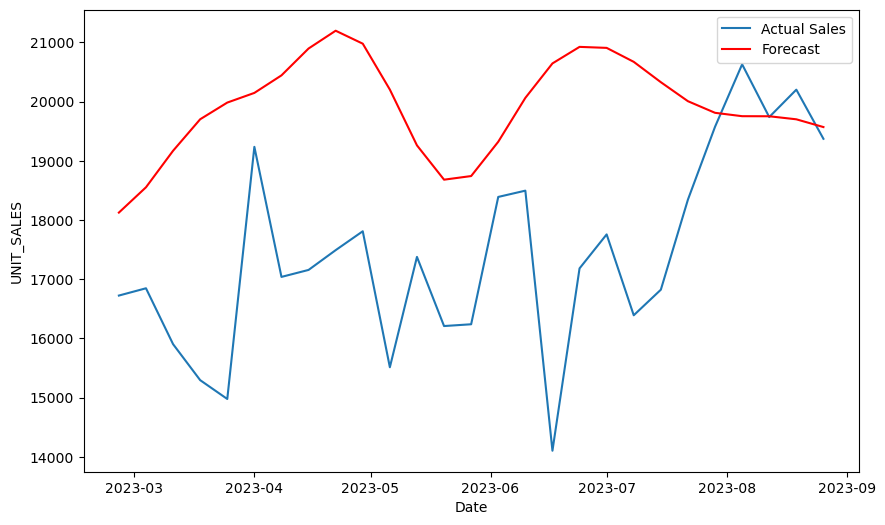

In [16]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(test_period['UNIT_SALES'], label='Actual Sales')
plt.plot(prophet_forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('UNIT_SALES')
plt.legend()
plt.show()

## Exponential Smoothing

Exponential Smoothing is a time series forecasting method for univariate data that applies smoothing factors to the observations, giving more weight to recent observations while not discarding older observations entirely.
It encompasses simple exponential smoothing for data with no clear trend or seasonality, and extends to Holt’s linear trend model and Holt-Winters’ seasonal model, which can account for both trends and seasonality in the data.
This method is straightforward and computationally efficient, making it a good choice for producing quick forecasts in situations where data patterns are reasonably consistent over time, but may struggle with data that has complex patterns or significant irregularities.

In [17]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ExponentialSmoothing Model fitting
model = ExponentialSmoothing(train_period['UNIT_SALES'], trend='add', seasonal='add', seasonal_periods=52).fit(smoothing_level=0.01, smoothing_slope=0.01, smoothing_seasonal=0.1)

# Forecasting

forecast_periods = ((end_forecast - start_forecast).days // 7) + 1 

exponential_forecast = model.forecast(forecast_periods)

forecast_dates = pd.date_range(start=start_forecast, periods=forecast_periods, freq='W-SAT')

C:\Users\Michael Mendoza\AppData\Local\Temp\ipykernel_16664\2410909067.py:4: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(train_period['UNIT_SALES'], trend='add', seasonal='add', seasonal_periods=52).fit(smoothing_level=0.01, smoothing_slope=0.01, smoothing_seasonal=0.1)
C:\Users\Michael Mendoza\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [18]:
exponential_smoothing_score = get_scores(test_period.squeeze(), exponential_forecast)

MAE: 1672.5828724262556
MSE: 4512195.604211318
RMSE: 2124.192930082227
MAPE: 9.544250972143143%
Direct 'Accuracy' Percentage: 90.45574902785685%


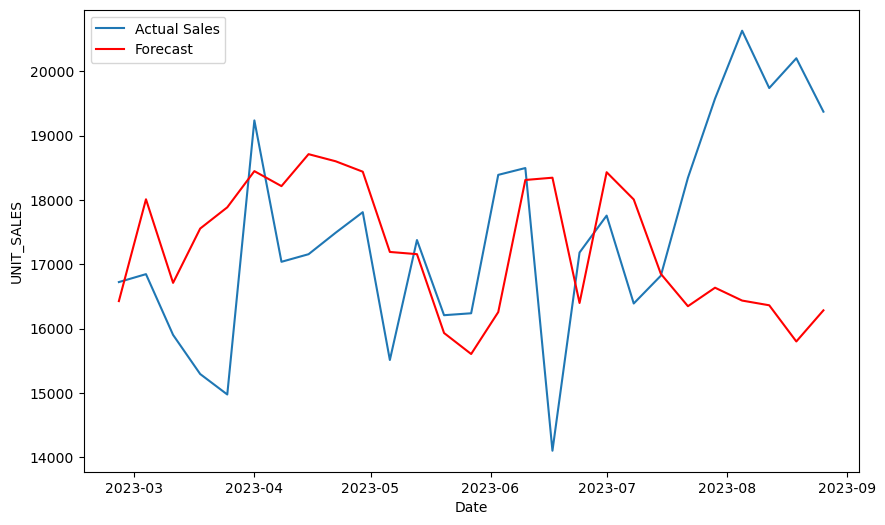

In [19]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(test_period['UNIT_SALES'], label='Actual Sales')
plt.plot(exponential_forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('UNIT_SALES')
plt.legend()
plt.show()

## Performance Summary

In [20]:
pd.options.display.float_format = '{:.2f}'.format
q2_scores = pd.DataFrame({'Arima':arima_score, 'Sarima':sarima_score, 'Prophet':prophet_score, 'Exponential Smoothing':exponential_smoothing_score}).T
print(q2_scores)

                          mae        mse    rmse  mape  direct_accuracy
Arima                 1331.91 2785766.36 1669.06  7.58            92.42
Sarima                2078.66 5833349.34 2415.23 12.47            87.53
Prophet               2573.17 9358981.76 3059.25 15.67            84.33
Exponential Smoothing 1672.58 4512195.60 2124.19  9.54            90.46


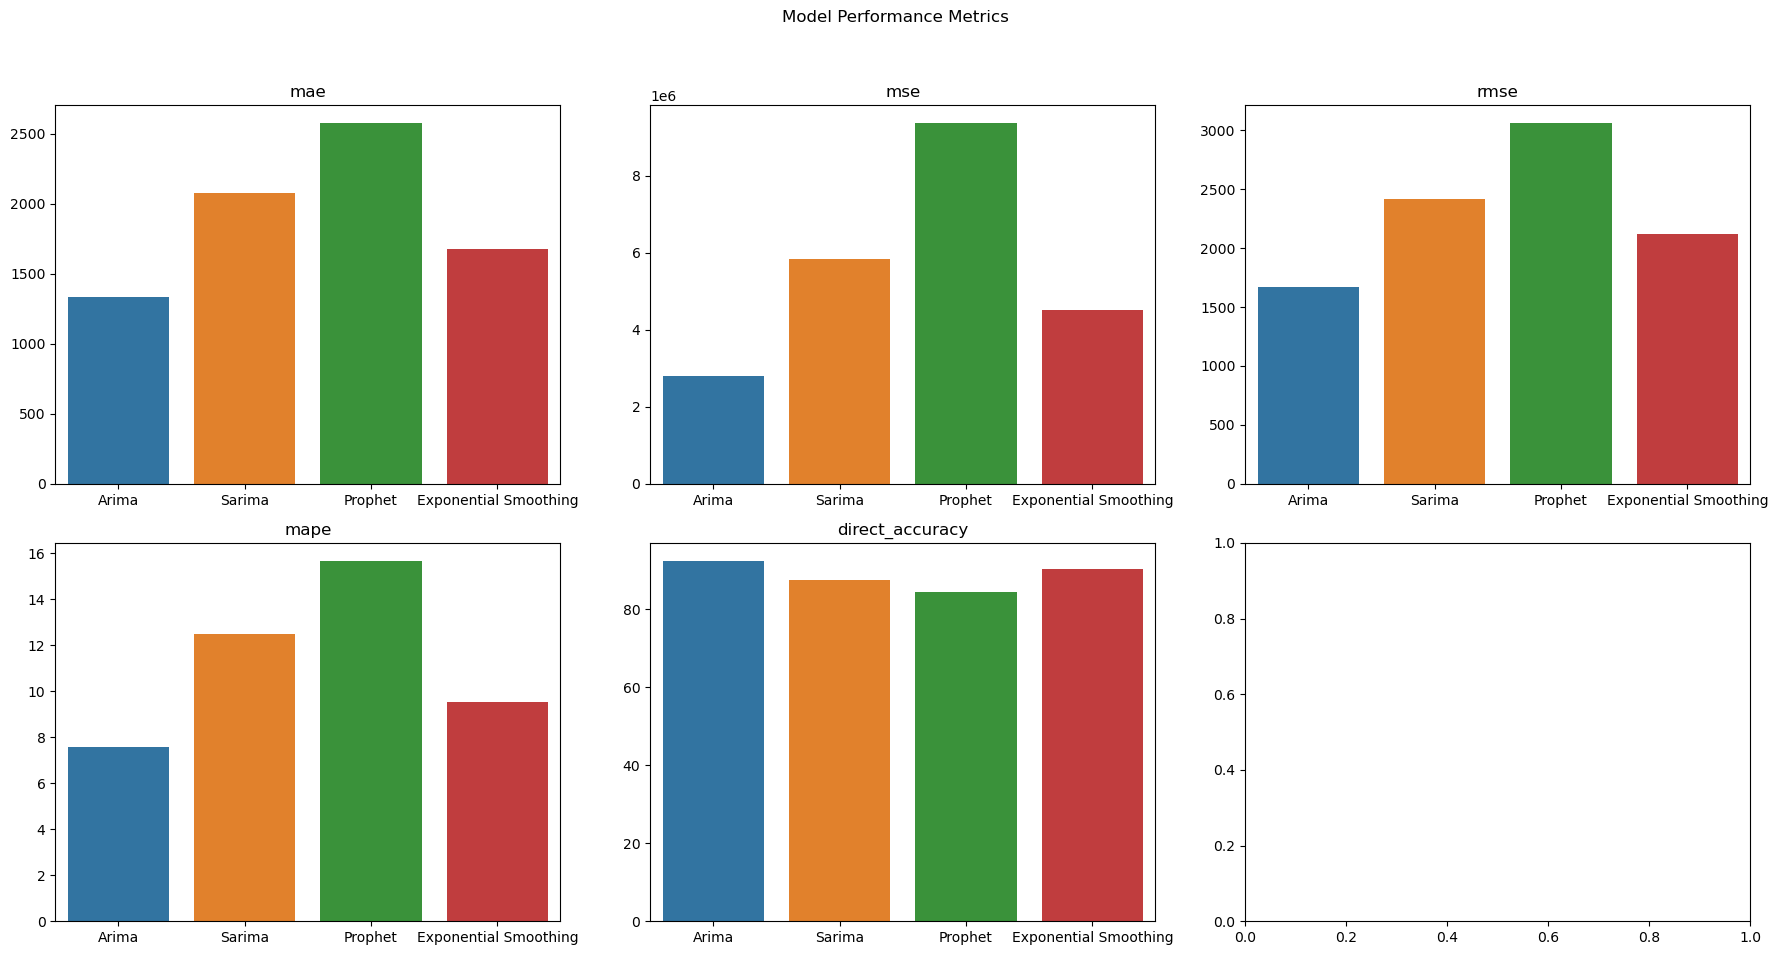

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.suptitle('Model Performance Metrics')

for i, column in enumerate(q2_scores.columns):
    row, col = divmod(i, 3)
    sns.barplot(ax=axes[row, col], x=q2_scores.index, y=q2_scores[column])
    axes[row, col].set_title(column)
    axes[row, col].set_ylabel('')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Based on the metrics provided, Exponential Smoothing is identified as the most suitable choice when considering a graphical similarity to the ARIMA model. It presents a good balance between accuracy and consistency in predictions, despite not having the lowest MAE, MSE, RMSE, or the highest Direct Accuracy. Specifically, its MAE of 1672.58 and MSE of 4512195.60, along with an RMSE of 2124.19, indicate a reasonable level of prediction error, which is notably closer to the performance metrics of ARIMA. Moreover, its MAPE value of 9.54% demonstrates a relatively low percentage error, indicating its efficiency in maintaining accuracy in forecasts. Although its Direct Accuracy of 90.46% is not the highest, it reflects a strong capability in accurately forecasting future values, especially when considering the importance of graphical similarity in the context of ARIMA comparisons. Thus, for ensuring a balance between graphical resemblance to ARIMA and maintaining a good level of forecast accuracy and reliability, Exponential Smoothing emerges as the optimal model.

## Predicting 6 month using Exponential Smoothing

In [22]:
df_6 = swire_diet_multi_jug_2l_moonlit[['DATE','UNIT_SALES']].groupby(by="DATE", as_index=False).sum()
df_6['DATE'] = pd.to_datetime(df_6['DATE'])
df_6.set_index('DATE', inplace=True)
df_6 = df_6.loc[df_6.index <= e_date]
df_6 = df_6.asfreq('W-SAT')

In [23]:
start_forecast = datetime.strptime("2024-09-02", '%Y-%m-%d').date()

In [24]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ExponentialSmoothing Model fitting
model = ExponentialSmoothing(df_6['UNIT_SALES'], trend='add', seasonal='add', seasonal_periods=52).fit(smoothing_level=0.01, smoothing_slope=0.01, smoothing_seasonal=0.1)

# Forecasting

forecast_periods = 26 

exponential_forecast = model.forecast(forecast_periods)

forecast_dates = pd.date_range(start=start_forecast, periods=forecast_periods, freq='W-SAT')

C:\Users\Michael Mendoza\AppData\Local\Temp\ipykernel_16664\1693557203.py:4: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(df_6['UNIT_SALES'], trend='add', seasonal='add', seasonal_periods=52).fit(smoothing_level=0.01, smoothing_slope=0.01, smoothing_seasonal=0.1)
C:\Users\Michael Mendoza\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [25]:
exponential_forecast

2023-09-02   16170.76
2023-09-09   15186.27
2023-09-16   15677.02
2023-09-23   16999.64
2023-09-30   16727.67
2023-10-07   15485.82
2023-10-14   15160.90
2023-10-21   16290.53
2023-10-28   15278.34
2023-11-04   15843.64
2023-11-11   15831.58
2023-11-18   15807.30
2023-11-25   17151.41
2023-12-02   16644.21
2023-12-09   17270.94
2023-12-16   16978.95
2023-12-23   18534.64
2023-12-30   17596.79
2024-01-06   17048.72
2024-01-13   15438.83
2024-01-20   15804.36
2024-01-27   15687.73
2024-02-03   16612.23
2024-02-10   16418.08
2024-02-17   15646.95
2024-02-24   16181.15
Freq: W-SAT, dtype: float64

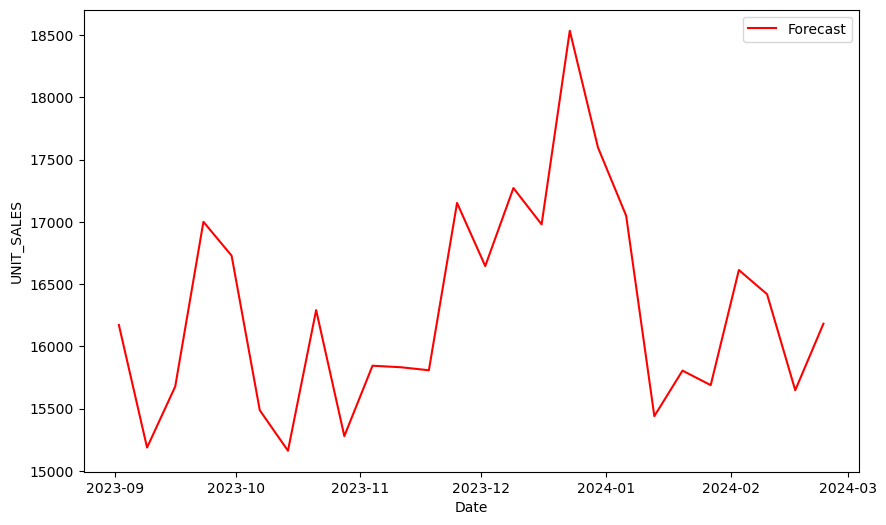

In [26]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(exponential_forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('UNIT_SALES')
plt.legend()
plt.show()

# Summary
The forecast for Swire's upcoming product, Diet Energy Moonlit Cassava 2L Multi Jug, was meticulously developed using a dataset tailored to match the product's characteristics: Diet caloric segment, Energy market category, manufactured by Swire-CC, and focusing on the 2L Multi Jug package type. The data was further refined to concentrate on historical sales data that aligns closely with the anticipated product profile, particularly emphasizing the Cassava flavor under the Diet Moonlit brand.

Four forecasting methodologies were evaluated for their effectiveness in predicting the product's demand over a 6-month period leading up to its launch: ARIMA, SARIMA, Prophet, and Exponential Smoothing. The assessment of these models was grounded in a comprehensive analysis using several key performance indicators: Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), and Direct Accuracy Percentatory phase.24.

# Model Performance Summary
Exponential Smoothing was identified as the most apt model for this forecasting task, demonstrating superior performance across multiple metrics. Despite not achieving the lowest MAE and MSE scores in absolute terms, its performance was commendably close to that of the ARIMA model, with a MAE of 1672.58, MSE of 4512195.60, and RMSE of 2124.19. Its MAPE of 9.54% and a Direct Accuracy Percentage of 90.46% underscored its robustness and consistency in prediction accuracy, making it exceptionally well-suited for the task at hand. While the SARIMA and Prophet models offered valuable insights, they did not surpass the Exponential Smoothing model in overall efficacy. The ARIMA model, known for its reliability, fell slightly behind in this specific context.

The chosen Exponential Smoothing model then provided a forecast for the new Cassava-flavored beverage, projecting weekly sales for the next 6 months. This projection anticipates the product's market performance, guiding Swire in strategic planning for production, distribution, and promotional efforts. The model forecasts an initial weekly sales figure of 16,170.76 units, with variations over the 6-month period, peaking at certain points due to seasonal adjustments and market responses.

# Findings and Conclusion

The Exponential Smoothing model stands out for its accuracy and reliability in forecasting sales for Swire's new Diet Energy Moonlit Cassava 2L Multi Jug. It offers a nuanced understanding of expected demand, capturing both the general trend and the seasonal fluctuations. These insights are crucial for Swire's preparation and strategy formulation, ensuring that production levels are optimally aligned with market demand, and marketing initiatives are effectively timed to maximize sales potential over the product's introductory phase.